# fastai Image类

构建fastai库使得加载的图片包裹在图像中。 此图像包含与图片关联的像素数组，但也有许多内置函数，可帮助fastai库处理应用于相应图像的转换。 还有特殊类型的图像对象的子类：

* 用于分段掩码的ImageSegment
* 用于边界框的ImageBBox

有关这些类的所有详细信息的文档，请参阅以下部分。 但首先，让我们快速浏览一下您需要了解的主要功能。

使用open_image函数可以轻松打开图像并转换为Image对象：

In [1]:
from fastai.vision import *
from fastai.basics import *
from fastai.callbacks import *

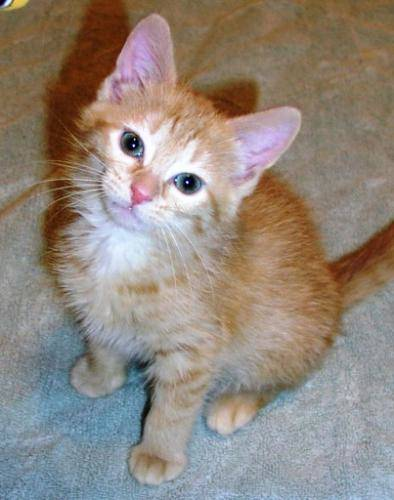

In [29]:
img = open_image('imgs/cat_example.jpg')
img

要查看此图像包含的图片，您还可以使用其show方法。 它将显示调整大小的版本，并有更多选项来自定义显示。

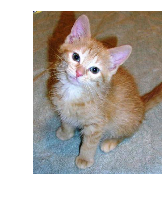

In [30]:
img.show()

这个show方法可以采用一些参数（有关详细信息，请参阅Image.show的文档），但我们将在本文档中使用最多的两个参数：

* ax是我们想要显示图像的matplolib.pyplot轴
* title 是我们可以给图像的可选标题。

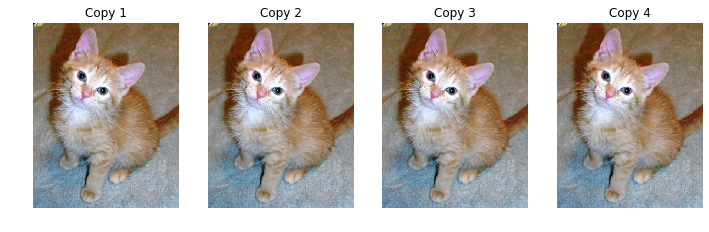

In [31]:
_,axs = plt.subplots(1,4,figsize=(12,4))
for i,ax in enumerate(axs): img.show(ax=ax, title=f'Copy {i+1}')

如果您对像素张量感兴趣，它会存储在Image的data属性中。

In [32]:
img.data.shape

torch.Size([3, 500, 394])

---

## Image类

图像是包装fastai库中每张图片的类。 在处理分段和对象检测任务时，它是创建ImageSegment和ImageBBox的子类。

**class Image**

`Image(px:Tensor) :: ItemBase`

支持将变换应用于px中的图像数据。

Image类的大多数函数都处理转换的内部管道，因此它们仅显示在本页末尾。 创建一个的最简单方法是通过open_image函数，如前所述。

**open_image**

`open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', after_open:Callable=None) → Image`

返回从文件fn中的图像创建的图像对象。

如果div = True，则像素值除以255.成为0和1之间的浮点数.convert_mode传递给PIL.Image.convert。

通过以下示例，您可以了解open_image如何使用不同的convert_mode。 对于所有模式，请在此处查看源。

```python
_MODE_CONV = {
    # official modes
    "1": ('|b1', None),  # Bits need to be extended to bytes
    "L": ('|u1', None),
    "LA": ('|u1', 2),
    "I": (_ENDIAN + 'i4', None),
    "F": (_ENDIAN + 'f4', None),
    "P": ('|u1', None),
    "RGB": ('|u1', 3),
    "RGBX": ('|u1', 4),
    "RGBA": ('|u1', 4),
    "CMYK": ('|u1', 4),
    "YCbCr": ('|u1', 3),
    "LAB": ('|u1', 3),  # UNDONE - unsigned |u1i1i1
    "HSV": ('|u1', 3),
    # I;16 == I;16L, and I;32 == I;32L
    "I;16": ('<u2', None),
    "I;16B": ('>u2', None),
    "I;16L": ('<u2', None),
    "I;16S": ('<i2', None),
    "I;16BS": ('>i2', None),
    "I;16LS": ('<i2', None),
    "I;32": ('<u4', None),
    "I;32B": ('>u4', None),
    "I;32L": ('<u4', None),
    "I;32S": ('<i4', None),
    "I;32BS": ('>i4', None),
    "I;32LS": ('<i4', None),
}
```

In [33]:
from fastai.vision import *

In [34]:
path_data = untar_data(URLs.PLANET_TINY); path_data.ls()

[WindowsPath('C:/Users/Yang/.fastai/data/planet_tiny/labels.csv'),
 WindowsPath('C:/Users/Yang/.fastai/data/planet_tiny/train')]

In [35]:
il = ImageList.from_folder(path_data/'train'); il

ImageList (200 items)
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: C:\Users\Yang\.fastai\data\planet_tiny\train

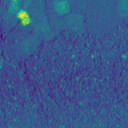

In [36]:
il.convert_mode = 'L'
il.open(il.items[10])

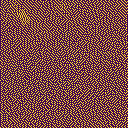

In [37]:
mode = '1'
open_image(il.items[10],convert_mode=mode)

正如我们所看到的，在Jupyter笔记本中，图像的表示是其底层图片（显示为其全尺寸）。 除了包含图像的像素张量（并且在解码图像之后自动进行转换）之外，该类包含用于实现变换的各种方法。 Image.show方法还允许传递更多参数：

**Image.show**

`Image.show(ax:Axes=None, figsize:tuple=(3, 3), title:Optional[str]=None, hide_axis:bool=True, cmap:str=None, y:Any=None, **kwargs)`

在带有标题的ax上显示图像，如果是单通道，则使用cmap，用可选的y覆盖

* ax：matplotlib.pyplot轴上显示图像
* figsize：图的大小
* title：显示在图表顶部的标题
* hide_axis：如果为True，则隐藏图形的轴
* cmap：要使用的颜色映射
* y：叠加在同一图形上的潜在目标（掩模，边界框，点）

这允许我们完全自定义图像的显示。 我们将在下面看到带有分段和边界框任务的y功能的示例，现在这里是使用其他功能的示例。

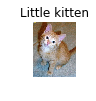

In [38]:
img.show(figsize=(2, 1), title='Little kitten')

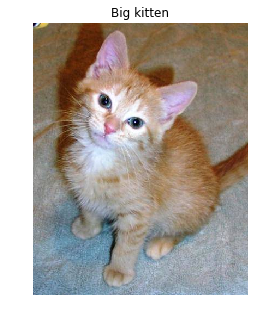

In [39]:
img.show(figsize=(10,5), title='Big kitten')

通过以下示例，您将了解如何为Image.show设置cmap。

有关cmap选项，请参阅matplotlib docs。 这就是fastai中定义defaults.cmap的方法，请参见此处的source。

`defaults = SimpleNamespace(cpus=_default_cpus, cmap='viridis', return_fig=False, silent=False)`

In [40]:
img.shape

torch.Size([3, 500, 394])

由于cmap适用于单个通道，因此需要设置convert_mode ='L'，以便将图像通道缩小为1。

torch.Size([1, 500, 394])


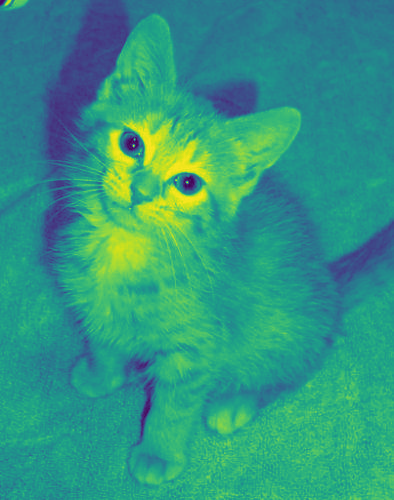

In [41]:
img = open_image('imgs/cat_example.jpg', convert_mode='L'); print(img.shape)
img

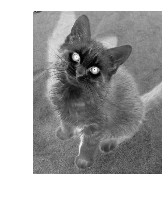

In [42]:
img.show(cmap='binary')

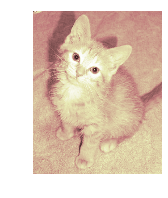

In [43]:
img.show(cmap='pink')

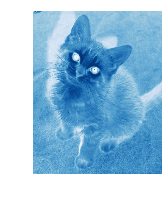

In [44]:
defaults.cmap = 'Blues'
img.show()

Image对象还有一些有用的属性：

* Image.data为您提供基础的像素张量
* Image.shape给出了张量的大小（通道x高x宽）
* Image.size为您提供图像的大小（高x宽）

In [45]:
img.data, img.shape, img.size

(tensor([[[0.0588, 0.0314, 0.0235,  ..., 0.3608, 0.3843, 0.3843],
          [0.0275, 0.0196, 0.0196,  ..., 0.3686, 0.3843, 0.3882],
          [0.0275, 0.0275, 0.0471,  ..., 0.3765, 0.3804, 0.3804],
          ...,
          [0.3725, 0.4392, 0.4431,  ..., 0.6235, 0.6549, 0.6549],
          [0.3961, 0.4745, 0.4784,  ..., 0.6706, 0.6588, 0.6588],
          [0.4510, 0.5373, 0.5412,  ..., 0.7294, 0.6549, 0.6549]]]),
 torch.Size([1, 500, 394]),
 torch.Size([500, 394]))

对于分段任务，目标通常是掩码。 fastai库将其表示为ImageSegment对象。

**class ImageSegment**

`ImageSegment(px:Tensor) :: Image`

支持将变换应用于分段屏蔽px中的数据。

为了轻松打开掩码，open_mask函数扮演与open_image相同的角色：

**open_mask**

`open_mask(fn:PathOrStr, div=False, convert_mode='L', after_open:Callable=None) → ImageSegment`

返回ImageSegment对象从文件fn中的掩码创建。 如果是div，则将像素值除以255。

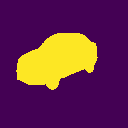

In [49]:
open_mask('imgs/mask_example.png')

**运行长度编码的掩码**

有时，您可能会遇到掩码数据作为运行长度编码字符串而不是图片。

In [50]:
df = pd.read_csv('imgs/mask_rle_sample.csv')
encoded_str = df.iloc[1]['rle_mask']; 
df[:2]

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...


您还可以在运行长度编码中读取遮罩，并为图像大小添加额外的参数形状

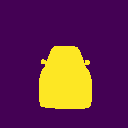

In [51]:
mask = open_mask_rle(df.iloc[0]['rle_mask'], shape=(1918, 1280)).resize((1,128,128))
mask

**open_mask_rle**

`open_mask_rle(mask_rle:str, shape:Tuple[int, int]) → ImageSegment`

返回ImageSegment对象，从mask_lre中的行程编码字符串创建，其大小为shape。

open_mask_rle只使用辅助函数rle_decode

In [52]:
rle_decode(encoded_str, (1912, 1280)).shape

(1912, 1280)

**rle_decode**

`rle_decode(mask_rle:str, shape:Tuple[int, int]) → ndarray`

从行程编码的字符串mask_rle返回带有形状的图像数组。

您还可以将ImageSegment转换为运行长度编码。

In [53]:
type(mask)

fastai.vision.image.ImageSegment

In [54]:
rle_encode(mask.data)

'5943 21 6070 25 6197 26 6324 28 6452 29 6579 30 6707 31 6835 31 6962 32 7090 33 7217 34 7345 35 7473 35 7595 2 7600 36 7722 5 7728 37 7766 4 7850 43 7894 5 7978 43 8022 5 8106 49 8238 44 8366 40 8494 41 8621 42 8748 44 8875 46 9003 47 9130 48 9258 49 9386 49 9513 50 9641 51 9769 51 9897 51 10024 52 10152 53 10280 53 10408 53 10536 53 10664 53 10792 53 10920 53 11048 53 11176 53 11304 53 11432 53 11560 53 11688 53 11816 53 11944 53 12072 53 12200 53 12328 53 12456 53 12584 53 12712 53 12840 53 12968 53 13097 51 13225 51 13353 51 13481 51 13610 49 13742 44 13880 30'

**rle_encode**

`rle_encode(img:ndarray) → str`

从img返回游程长度编码字符串。

ImageSegment对象具有与Image相同的属性。 唯一的区别是，当将变换应用于ImageSegment时，它将忽略处理光照的函数并保持0和1的值。如前所述，通过使用y参数可以很容易地在关联的图像上显示分割蒙版 show_image。

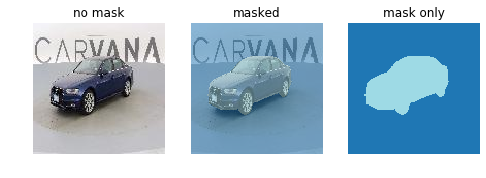

In [55]:
img = open_image('imgs/car_example.jpg')
mask = open_mask('imgs/mask_example.png')
_,axs = plt.subplots(1,3, figsize=(8,4))
img.show(ax=axs[0], title='no mask')
img.show(ax=axs[1], y=mask, title='masked')
mask.show(ax=axs[2], title='mask only', alpha=1.)

当目标是一堆点时，以下类将有所帮助。

**class ImagePoints**

`ImagePoints(flow:FlowField, scale:bool=True, y_first:bool=True) :: Image`

支持将变换应用于点流。

从坐标流创建ImagePoints对象。 如果将比例保留为True，则需要将坐标缩放到范围（-1,1），这将在初始化中完成。 惯例是以[y，x]的形式得到点坐标，除非y_first设置为False。

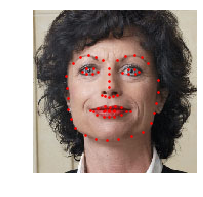

In [56]:
img = open_image('imgs/face_example.jpg')
pnts = torch.load('imgs/points.pth')
pnts = ImagePoints(FlowField(img.size, pnts))
img.show(y=pnts)

请注意，原始点在FlowField对象中收集，该对象是将一组坐标与相应图像大小包装在一起的类。 在fastai中，我们希望点默认为y坐标在第一。 `pnts`的基础数据是从-1缩放到1的点流（同样首先是y坐标）：

In [57]:
pnts.data[:10]

tensor([[-0.1875, -0.6000],
        [-0.0500, -0.5875],
        [ 0.0750, -0.5750],
        [ 0.2125, -0.5750],
        [ 0.3375, -0.5375],
        [ 0.4500, -0.4875],
        [ 0.5250, -0.3750],
        [ 0.5750, -0.2375],
        [ 0.5875, -0.1000],
        [ 0.5750,  0.0375]])

对于异议检测任务，目标是包含图片的边界框。
**class ImageBBox**

`ImageBBox(flow:FlowField, scale:bool=True, y_first:bool=True, labels:Collection[T_co]=None, classes:dict=None, pad_idx:int=0) :: ImagePoints`

支持将变换应用于边界框流。

从坐标流创建ImageBBox对象。如果我们有N个bbox，那么这些坐标应该在FlowField中，其底层流量为4N，为每个框描述左上角，右上角，左下角，右下角。如果将比例保留为True，则需要将坐标缩放到范围（-1,1），这将在初始化中完成。惯例是以[y，x]的形式得到点坐标，除非y_first设置为False。 labels是标签的可选集合，其大小应与flow相同。如果变换集以某种方式离开图像而没有任何边界框，则使用pad_idx。

要创建ImageBBox，可以使用create helper函数，该函数获取边界框列表，输入图像的高度以及输入图像的宽度。每个边界框由四个数字的列表表示：框的角的坐标具有以下约定：顶部，左侧，底部，右侧。

**create**

`create(h:int, w:int, bboxes:Collection[Collection[int]], labels:Collection[T_co]=None, classes:dict=None, pad_idx:int=0, scale:bool=True) → ImageBBox`

从bboxes创建一个ImageBBox对象。

* h：输入图像的高度
* w：输入图像的宽度
* bboxes：bboxes列表（每个都是带有top，left，bottom，right约定的四个整数）
* 标签：图像的标签（作为索引）
* classes：相应的类
* pad_idx：用于批量分组ImageBBox的填充索引
* scale：如果为True，则将边界框从-1缩放为1

我们需要传递输入图像的尺寸，以便ImageBBox可以在内部创建FlowField。 同样，Image.show方法将在同一图像上显示边界框，如果它作为y参数传递。

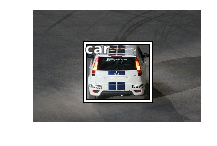

In [58]:
img = open_image('imgs/car_bbox.jpg')
bbox = ImageBBox.create(*img.size, [[96, 155, 270, 351]], labels=[0], classes=['car'])
img.show(y=bbox)

为了帮助转换图像或显示它们，我们使用这些辅助函数：

**show_image**

`show_image（img：Image，ax：Axes = None，figsize：tuple =（3,3），hide_axis：bool = True，cmap：str ='binary'，alpha：float = None，** kwargs）→Axes`

在笔记本中显示图像。

**pil2tensor**

`pil2tensor(image:ndarray, dtype:dtype) → Tensor`

将PIL样式图像阵列转换为手电筒样式图像张量。

In [59]:
pil2tensor(PIL.Image.open('imgs/cat_example.jpg').convert("RGB"), np.float32).div_(255).size() 

torch.Size([3, 500, 394])

In [60]:
pil2tensor(PIL.Image.open('imgs/cat_example.jpg').convert("I"), np.float32).div_(255).size()

torch.Size([1, 500, 394])

In [61]:
pil2tensor(PIL.Image.open('imgs/mask_example.png').convert("L"), np.float32).div_(255).size()

torch.Size([1, 128, 128])

In [62]:
pil2tensor(np.random.rand(224,224,3).astype(np.float32), np.float32).size()

torch.Size([3, 224, 224])

In [63]:
pil2tensor(PIL.Image.open('imgs/cat_example.jpg'), np.float32).div_(255).size()

torch.Size([3, 500, 394])

In [64]:
pil2tensor(PIL.Image.open('imgs/mask_example.png'), np.float32).div_(255).size()

torch.Size([1, 128, 128])

**image2np**

`image2np(image:Tensor) → ndarray`

从火炬风格图像转换为numpy / matplotlib风格。

**scale_flow**

`scale_flow(flow, to_unit=True)`

将流中的坐标缩放到-1/1或图像大小取决于to_unit。

**bb2hw**

`bb2hw(a:Collection[int]) → ndarray`

将边界框点从（宽度，高度，中心）转换为（高度，宽度，顶部，左侧）。

In [66]:
doc(tis2hw)

**tis2hw**

`tis2hw(size:Union[int, TensorImageSize]) → Tuple[int, int]`

将int或TensorImageSize转换为图像的（高度，宽度）。

如果提供的大小为（int，int），则tis2hw将按原样返回。 如果以str格式传入大小，则tis2hw将引发RuntimeError

---

## 可视化功能

**show_all**

`show_all(imgs:Collection[Image], r:int=1, c:Optional[int]=None, figsize=(12, 6))`

使用r行显示所有imgs

**plot_flat**

`plot_flat(r, c, figsize)`

枚举的快捷方式（subplots.flatten（））

**plot_multi**

`plot_multi(func:Callable[int, int, Axes, NoneType], r:int=1, c:int=1, figsize:Tuple=(12, 6))`

在子图上为r，c的每个组合调用func

在内部，它首先创建r $ \ times $ c个子图，分配到轴中，然后遍历每个轴以创建带有func的图。

**show_multi**

`show_multi(func:Callable[int, int, Image], r:int=1, c:int=1, figsize:Tuple=(9, 9))`

为r，c的每个组合调用func（i，j）.show（ax）

---

## 应用变换

可用于计算机视觉中的数据增强的所有变换都在vision.transform模块中定义。 当我们想将它们应用于Image时，我们使用以下方法：

**apply_tfms**

`apply_tfms(tfms:Union[Callable, Collection[Callable]], do_resolve:bool=True, xtra:Optional[Dict[Callable, dict]]=None, size:Union[int, TensorImageSize, NoneType]=None, resize_method:ResizeMethod=None, mult:int=None, padding_mode:str='reflection', mode:str='bilinear', remove_out:bool=True) → Tensor`

如果do_resolve选择随机args的值，则将所有tfms应用于Image。

* tfms：变换或变换列表
* do_resolve：如果为False，则从最后一次绘制中保留随机参数的值
* xtra：传递给变换的额外参数
* size：所需目标尺寸
* mult：确保最终大小是mult的倍数
* resize_method：如何达到最终尺寸（裁剪，垫，挤压）
* padding_mode：如何填充图像（'零'，'边框'，'反射'）

在展示示例之前，让我们花点时间对这些论点进行更多评论：

* do_resolve决定我们是否通过绘制新数字来解析随机参数。预期用途是使用do_resolve = True将tfms应用于输入x，然后，如果目标y需要应用数据扩充（如果它是分段掩码或边界框），则将tfms应用于y，并使用do_resolve = False 。
* mult 默认值非常重要，以确保您的图像可以通过最近的CNN：它们将输入图像的大小分成2倍，因此图片的两个维度应该是至少为32的多个。只更改此值参数如果您知道它将被您的模型接受。
这里有一些辅助函数可以帮助我们加载我们之前看到的示例。

In [73]:
def get_class_ex(): return open_image('imgs/cat_example.jpg')
def get_seg_ex(): return open_image('imgs/car_example.jpg'), open_mask('imgs/mask_example.png')
def get_pnt_ex():
    img = open_image('imgs/face_example.jpg')
    pnts = torch.load('imgs/points.pth')
    return img, ImagePoints(FlowField(img.size, pnts))
def get_bb_ex():
    img = open_image('imgs/car_bbox.jpg')
    return img, ImageBBox.create(*img.size, [[96, 155, 270, 351]], labels=[0], classes=['car'])

现在让我们抓住我们通常的一系列变换，看看他们做了什么。

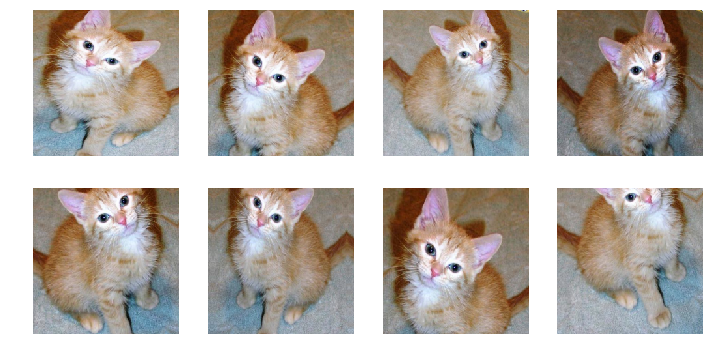

In [69]:
tfms = get_transforms()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = get_class_ex().apply_tfms(tfms[0], get_class_ex(), size=224)
    img.show(ax=ax)

现在让我们检查它为分段任务提供的内容。 请注意，按照apply_tfms文档的说明，我们首先将变换应用于输入，然后在添加do_resolve = False时将它们应用于目标。

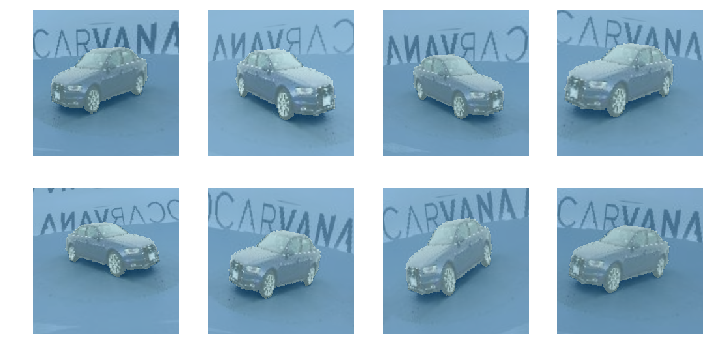

In [70]:
tfms = get_transforms()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img,mask = get_seg_ex()
    img = img.apply_tfms(tfms[0], size=224)
    mask = mask.apply_tfms(tfms[0], do_resolve=False, size=224)
    img.show(ax=ax, y=mask)

在内部，每个转换都会将随机选取的值保存到名为resolved的字典中，并且可以将其重用于目标。

In [71]:
tfms[0][4]

RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={'scale': 1.0571837956159125, 'row_pct': 0.225062150072599, 'col_pct': 0.8121390573929481}, do_run=True, is_random=True, use_on_y=True)

对于点，ImagePoints将变换应用于坐标。

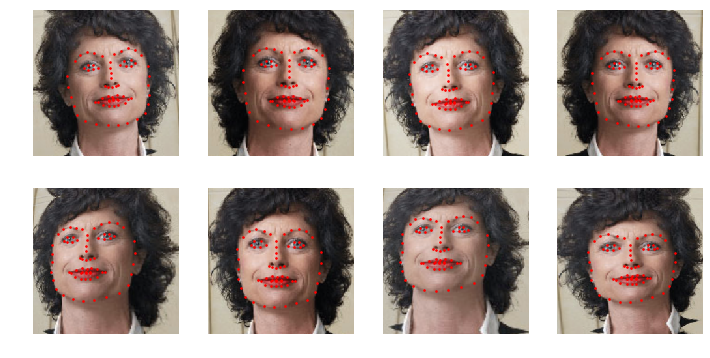

In [74]:
tfms = get_transforms()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img,pnts = get_pnt_ex()
    img = img.apply_tfms(tfms[0], size=224)
    pnts = pnts.apply_tfms(tfms[0], do_resolve=False, size=224)
    img.show(ax=ax, y=pnts)

现在对于边界框，ImageBBox将自动更新其数据属性中两个对角的坐标。

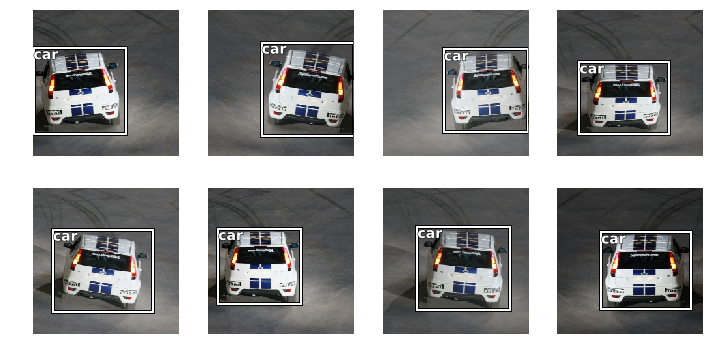

In [75]:
tfms = get_transforms()
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img,bbox = get_bb_ex()
    img = img.apply_tfms(tfms[0], size=224)
    bbox = bbox.apply_tfms(tfms[0], do_resolve=False, size=224)
    img.show(ax=ax, y=bbox)

---

## Fastai内部管道

**变换有什么作用？**

通常，数据增强操作将随机修改图像输入。此操作可应用于像素（例如，当我们修改对比度或亮度时）或坐标（当我们进行旋转，缩放或调整大小时）。适用于像素的操作可以很容易地在numpy / pytorch中编码，直接在数组/张量上编码，但修改坐标的操作有点棘手。

它们通常分为三个步骤：首先我们为我们的图片创建一个坐标网格：这是一个大小为h * w * 2的数组（h为高度，w为本文其余部分的宽度），包含在位置i， j两个浮点数表示图像中像素（i，j）的位置。它们可以简单地是整数i和j，但由于大多数变换以图像的中心为原点居中，它们通常被重新调整为从-1到1，（-1，-1）是左上角如图所示，（1,1）右下角（和（0,0）中心），这可以看作是大小为h * w的规则网格。这是我们的网格对于5px乘5px图像的样子。

然后，我们应用转换来修改这个坐标网格。 例如，如果我们想要应用仿射变换（如旋转），我们将在网格中的每个位置将每个大小为2的向量x转换为A @ x + b。 这将为我们提供新的坐标，如我们之前的网格所示。

变换后出现两个问题：第一个是像素值不会精确地落在网格上，另一个是我们可以得到离开网格的值（其中一个坐标大于1或低于-1）。

为了解决第一个问题，我们使用插值。如果我们忘记了一分钟的重新缩放并返回到整数坐标，我们转换的结果给出了浮点坐标，我们需要为每个（i，j）决定原始图片中我们需要的像素值采取。最基本的插值称为最近邻居，它将围绕浮点数并取最近的整数。如果我们根据坐标网格（从-1到1）进行思考，我们转换的结果会给出一个不在网格中的点，我们将它替换为网格中最近的邻居。

为了更聪明，我们可以执行双线性插值。这取得了与我们变换结果周围的网格中的四个点相对应的像素值的平均值，权重取决于我们与每个点的接近程度。这需要计算成本，所以这是我们必须小心的地方。

至于图片中的值，我们通过填充它来处理它们：

* 通过在侧面添加零，所以掉出的像素将是黑色（零填充）
* 通过边界处的值替换它们（边框填充）
* 通过镜像另一侧图片的内容（反射填充）。

**要聪明，高效**

通常，数据扩充库将不同的操作分开。 因此，对于调整大小，我们将完成上面的三个步骤，然后如果我们进行随机旋转，我们将再次执行这些步骤，然后进行缩放等...快速库的工作方式与 它将同时对坐标进行所有变换，因此我们只执行这三个步骤，尤其是最后一个（插值）是计算中最重的。

首先，我们可以在一次通过中重新组合所有仿射变换（因为由仿射变换组成的仿射变换是另一个仿射变换）。 这已经在其他一些库中完成了，但我们将其推进了一步。 我们在同一过程中集成了调整大小，裁剪和坐标的任何非仿射变换。 我们来挖掘吧！

* 在步骤1中，当我们创建网格时，我们使用我们想要的新图像，即new_h，new_w（而不是h，w）。 这将负责调整大小操作。

* 在步骤2中，我们只做一个仿射变换，通过将我们想要预先做的变换的所有仿射矩阵相乘（那些是3乘3矩阵，所以它超快）。 然后我们在坐标之前应用我们可能需要的任何非仿射变换（抖动，透视包装等）...

* 步骤2.5：我们裁剪（中心或随机）我们想要保留的坐标。 可以在任何时候进行裁剪，但是通过在插值之前进行裁剪，我们不计算最终不会使用的像素值，再次获得一点效率

* 最后第3步：最终插值。 之后，我们可以在图片上应用按像素操作的所有变换（例如亮度或对比度），我们已完成数据增强。

请注意，对像素进行操作的变换分两个阶段应用：

* 首先，处理光照属性的变换应用于像素的对数。 我们将它们组合在一起，因此我们只需要进行转换像素 - > logits  - >像素转换一次。

* 然后我们应用修改像素的变换。

这就是为什么所有变换都具有属性（例如TfmAffine，TfmCoord，TfmCrop或TfmPixel）的原因，以便fastai库可以重新组合它们并在正确的步骤中将它们全部应用在一起。 在实施方面：

* `_affine_grid`负责创建坐标网格
* `_affine_mult`负责在该网格上进行仿射乘法
* `_grid_sample`是负责插值步骤的函数

**最后结果**

TODO：添加速度比较。

添加新转换不会对性能产生太大影响（因为昂贵的步骤只执行一次）。 与具有经典数据增强实现的其他库相比，增强通常导致更长的训练时间。

就最终结果而言，仅进行一次插值也会产生更好的结果。 如果我们堆叠几个变换并对每个变换进行插值，我们会以某种方式逼近坐标的真值。 这往往会使图像模糊一点，这通常会对性能产生负面影响。 通过将所有变换重新组合在一起并且仅在最后执行此步骤，图像通常不那么模糊，并且模型通常表现得更好。

查看相同的旋转然后单独进行缩放（因此有两个插值）：

比重新组合变换并只做一次插值更模糊：

**`ResizeMethod`**

`Enum = [CROP，PAD，SQUISH，NO]`

调整方法以将图像转换为给定大小：

* crop：调整大小以使图像在较小的一侧适合所需的画布并裁剪
* pad：调整大小以使图像在较大的一侧适合所需的画布并裁剪
* squish：通过将其压在所需的画布上来调整图像大小
* np：不调整图像大小

---

## Transform classes

在fastai库中定义转换的基本类是Transform。

**class Transform**

`Transform(func:Callable, order:Optional[int]=None)`

为func创建一个Transform并为其分配一个优先级顺序。

**class RandTransform**

`RandTransform(tfm:Transform, kwargs:dict, p:float=1.0, resolved:dict=<factory>, do_run:bool=True, is_random:bool=True, use_on_y:bool=True)`

换行以添加随机执行。

分析kwargs中func的每个参数，如果它具有一个随机函数的类型annotaiton，将调用此函数为其选择一个值。 该值将存储在已解析的字典中。 遵循相同的想法，p是func被调用的概率，如果是原因，do_run将被设置为True，否则为False。 将is_random设置为False允许为每个参数发送特定值。 use_on_y是进一步控制目标变换的参数（例如，分段掩码）。 假设使用tfm_y = True（在数据块管道中）打开标签上的转换，use_on_y = False可以禁用标签的转换。

**resolve**

`resolve()`

绑定变换中的任何随机变量。

要在内部处理数据扩充，如前所述，每个Transform都作为一种类型，以便fastai库可以有效地将它们重新组合在一起。 有五种类型的Transform，它们都作为确定性函数的装饰器。

**class TfmAffine**

`TfmAffine(func:Callable, order:Optional[int]=None) :: Transform`

用于仿射tfm功能的装饰器。

func应返回表示变换的3乘3矩阵。 此类转换的默认顺序为5。

**class TfmCoord**

`TfmCoord(func:Callable, order:Optional[int]=None) :: Transform`

用于coord tfm功能的装饰器。

func应该采用两个强制参数：c（坐标流）和img_size（相应图像的大小）并返回修改后的坐标流。 此类转换的默认顺序为4。

**class TfmLighting**

`TfmLighting(func:Callable, order:Optional[int]=None) :: Transform`

用于照明tfm功能的装饰器。

func获取像素张量的logits并更改它们。 此类转换的默认顺序为8。

**class TfmPixel**

`TfmPixel(func:Callable, order:Optional[int]=None) :: Transform`

用于像素tfm功能的装饰器。

func采用像素张量并修改它。 此类转换的默认顺序为10。

**class TfmCrop**

`TfmCrop(func:Callable, order:Optional[int]=None) :: TfmPixel`

用于作物tfm功能的装饰器。

这是TfmPixel的特殊情况，订单设置为99。

---

## Image类的内部函数

所有Image类都具有相同的内部函数来处理数据扩充。

**affine**

`affine(func:AffineFunc, *args, **kwargs) → Image`

相当于image.affine_mat = image.affine_mat @ func（）。

**clone**

`clone()`

模仿torch.clone对Image对象的行为。

**coord**

`coord(func:Callable[FlowField, ArgStar, KWArgs, Tensor], *args, **kwargs) → Image`

相当于image.flow = func（image.flow，image.size）。

**lighting**

`lighting(func:LightingFunc, *args:Any, **kwargs:Any)`

相当于image = sigmoid（func（logit（image）））。

**pixel**

`pixel(func:LightingFunc, *args, **kwargs) → Image`

相当于image.px = func（image.px）。

**refresh**

`refresh()`

应用已发送到Image的任何logit，flow或仿射传输。

**resize**

`resize(size:Union[int, TensorImageSize]) → Image`

将图像大小调整为大小，大小可以是单个int。

**save**

`save(fn:PathOrStr)`

将图像保存到fn。

**class FlowField**

`FlowField(size:Tuple[int, int], flow:Tensor)`

将一些Coords流包裹在一起。